## 데이터 로드

In [39]:
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import re

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [40]:
# .txt파일로 불러옴
path_to_train_file = tf.keras.utils.get_file('train.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt')
path_to_test_file = tf.keras.utils.get_file('test.txt', 'https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt')

In [41]:
train_text = open(path_to_train_file, 'rb').read().decode(encoding='utf-8') # 'rb'로 읽으면 다르게 encoding 된 것도 읽을 수 있음(binary로 읽음)
test_text = open(path_to_test_file, 'rb').read().decode(encoding='utf-8')

print('Length of text (train): {} '.format(len(train_text)))
print('Length of text (test): {} '.format(len(test_text)))

# id : 각 data의 고유 id
# document : review 내용
# label : 긍정(1) / 부정(0)
print(train_text[:300])

Length of text (train): 6937271 
Length of text (test): 2318260 
id	document	label
9976970	아 더빙.. 진짜 짜증나네요 목소리	0
3819312	흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나	1
10265843	너무재밓었다그래서보는것을추천한다	0
9045019	교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정	0
6483659	사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 던스트가 너무나도 이뻐보였다	1
5403919	막 걸음마 뗀 3세부터 초등학교 1학년생인 8살용영화.ㅋㅋㅋ...별반개도 아까움.	0
7797314	원작의


## Target data 만들기

In [42]:
# 학습 정답 데이터 만들기
train_Y = np.array([[int(row.split('\t')[2])] for row in train_text.split('\n')[1:] if row.count('\t') > 0])
test_Y = np.array([[int(row.split('\t')[2])] for row in test_text.split('\n')[1:] if row.count('\t') > 0])

print(train_Y.shape, test_Y.shape)
print(train_Y[:5])
print()
print(test_Y[:5])

(150000, 1) (50000, 1)
[[0]
 [1]
 [0]
 [0]
 [1]]

[[1]
 [0]
 [0]
 [0]
 [0]]


## 훈련 데이터의 정제
* input으로는 토큰화(Tokenization)하고 정제(Cleansing)해야합니다.

Tokenization : 자연어를 처리 가능한 작은 단위로 나누는 것

Cleansing :  원하지 않는 입력이나 불필요한 기호 등을 제거한다.


In [43]:
# word preprocessing
def clean_str(string):
    string = re.sub(r"[^가-힣A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    string = re.sub(r"\'{2,}", "\'", string)
    string = re.sub(r"\'", "", string)

    return string.lower()

train_text_X = [row.split('\t')[1] for row in train_text.split('\n')[1:] if row.count('\t') > 0]
train_text_X = [clean_str(sentence) for sentence in train_text_X]
# 문장을 띄어쓰기 단위로 단어 분리
sentences = [sentence.split(' ') for sentence in train_text_X]
for i in range(5):
    print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조차', '가볍지', '않구나']
['너무재밓었다그래서보는것을추천한다']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그의', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨에서', '늙어보이기만', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


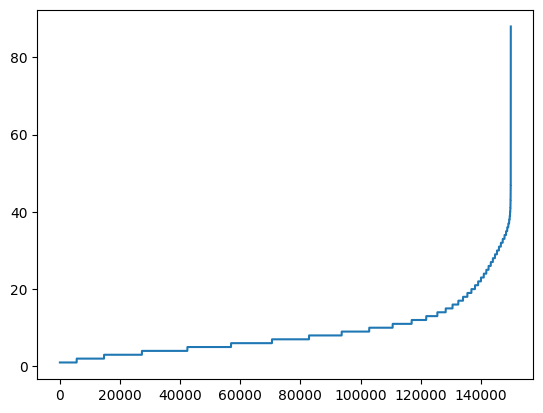

142587


In [44]:
# network에 입력하려면, data의 크기(문장의 길이)는 동일해야한다.
# 긴 문장은 줄이고, 짧은 문장에는 공백을 의미하는 padding을 넣어야한다.
sentence_len = [len(sentence) for sentence in sentences]
sentence_len.sort()

plt.plot(sentence_len)
plt.show()

print(sum([int(l<=25) for l in sentence_len])) # 25개 이상 -> 기준이 되는 문장의 길이, 25이상은 생략, 이 이하는 padding으로 길이를 25로 맞춘다.

In [45]:
# # 각 단어의 최대 길이를 조정한다.
# # "스파이더맨에서" 글에서 "에서"의 조사를 제거하면 "스파이더맨" 이라는 단어가 된다.
# sentence_new = []
# for sentence in sentences:
#   new_sentence = []
#   for word in sentence:
#     new_sentence.append(word[:5]) # 각 sentence에서 5글자만 꺼내옴

#   # 25글자가 넘게 되면, 그 이상을 생략
#   if len(new_sentence) > 25:
#     new_sentence = new_sentence[:25]
#   sentence_new.append(new_sentence)

# sentence = sentence_new

# for i in range(5):
#     print(sentence[i])
sentence_new = []
for sentence in sentences:
  sentence_new.append([word[:5] for word in sentence][:25])

sentences = sentence_new

for i in range(5):
  print(sentences[i])

['아', '더빙', '진짜', '짜증나네요', '목소리']
['흠', '포스터보고', '초딩영화줄', '오버연기조', '가볍지', '않구나']
['너무재밓었']
['교도소', '이야기구먼', '솔직히', '재미는', '없다', '평점', '조정']
['사이몬페그', '익살스런', '연기가', '돋보였던', '영화', '!', '스파이더맨', '늙어보이기', '했던', '커스틴', '던스트가', '너무나도', '이뻐보였다']


In [46]:
# 25글자로 바꾸고 padding을 넣는 작업
# pad_sequences : padding을 넣기 위함
# 모든 단어를 사용하지 않고, 출현 빈도가 가장 높은 일부 단어만 사용 -> Tokenizer 사용

tokenizer = Tokenizer(num_words = 2000) # 가장 빈도가 높은 상위 num_words개의 단어만을 선택하여 토큰으로 만든다. (상위 2000개)
tokenizer.fit_on_texts(sentences) # data를 실제로 입력한다.
train_X = tokenizer.texts_to_sequences(sentences) # 각 단어를 숫자로 변환한다.
train_X = pad_sequences(train_X, padding = 'post') # pre : 문장의 맨 앞에 padding, post : 문장의 맨 뒤에 padding

train_X[:10]

array([[  25,  884,    8, 1111,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 588,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [  71,  346,   31,   35,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 106,    4,    2,  869,  573,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0],
       [ 583,  404,    1,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,  

In [47]:
for idx, word in enumerate(range(1, 26), 0):
  print(idx, tokenizer.index_word[word])

0 
1 !
2 ,
3 영화
4 \?
5 너무
6 정말
7 진짜
8 이
9 그냥
10 왜
11 이런
12 더
13 수
14 영화를
15 다
16 잘
17 보고
18 좀
19 영화는
20 영화가
21 그
22 봤는데
23 본
24 아


## 딥러닝 모형 정의 및 학습

* embedding Layer

* LSTM Layer

* Dense Layer

embedding layer와 LSTM layer를 연결한 뒤, 마지막에 Dense Layer의 softmax 함수 사용 후 sentiment classification

In [48]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(20000, 300, input_length = 25), # input dim : 20,000, output dim : 300, input length : 25
    tf.keras.layers.LSTM(units = 50),
    tf.keras.layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 25, 300)           6000000   
                                                                 
 lstm_3 (LSTM)               (None, 50)                70200     
                                                                 
 dense_3 (Dense)             (None, 2)                 102       
                                                                 
Total params: 6070302 (23.16 MB)
Trainable params: 6070302 (23.16 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
# 모델 학습
history = model.fit(train_X, train_Y, epochs = 10, batch_size = 128, validation_split = 0.2)

Epoch 1/10
938/938 [==============================] - 21s 21ms/step - loss: 0.4887 - accuracy: 0.7405 - val_loss: 0.4579 - val_accuracy: 0.7644
Epoch 2/10
938/938 [==============================] - 8s 8ms/step - loss: 0.4481 - accuracy: 0.7645 - val_loss: 0.4557 - val_accuracy: 0.7682
Epoch 3/10
938/938 [==============================] - 7s 8ms/step - loss: 0.4380 - accuracy: 0.7699 - val_loss: 0.4488 - val_accuracy: 0.7694
Epoch 4/10
938/938 [==============================] - 7s 8ms/step - loss: 0.4285 - accuracy: 0.7741 - val_loss: 0.4481 - val_accuracy: 0.7692
Epoch 5/10
938/938 [==============================] - 7s 8ms/step - loss: 0.4204 - accuracy: 0.7774 - val_loss: 0.4503 - val_accuracy: 0.7676
Epoch 6/10
938/938 [==============================] - 8s 9ms/step - loss: 0.4112 - accuracy: 0.7834 - val_loss: 0.4590 - val_accuracy: 0.7589
Epoch 7/10
938/938 [==============================] - 6s 7ms/step - loss: 0.4017 - accuracy: 0.7896 - val_loss: 0.4626 - val_accuracy: 0.7661
Epoc

## 학습 결과 테스트

* train과 똑같은 전처리 과정

In [50]:
test_text_X = [row.split('\t')[1] for row in test_text.split('\n')[1:] if row.count('\t') > 0]
test_text_X = [clean_str(sentence) for sentence in test_text_X]

# 문장을 띄어쓰기 단위로 단어 분리
sentences = [sentence.split(' ') for sentence in test_text_X]
sentence_new = []
for sentence in sentences:
  sentence_new.append([word[:5] for word in sentence][:25])

sentences = sentence_new

test_X = tokenizer.texts_to_sequences(sentences)
test_X = pad_sequences(test_X, padding='post')

In [51]:
model.evaluate(test_X, test_Y, verbose=0)

[0.5103679895401001, 0.7567399740219116]